In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from tensorflow.keras.applications import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
import keras.backend as K
from glob import glob

# re-size all the images to this
IMAGE_SIZE = [224, 224]

# add preprocessing layer to the front of resnet
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
#changing last layer


# don't train existing weights
for layer in vgg16.layers:
  layer.trainable = False
  #traning only the last layer


# our layers - you can add more if you want
x = Flatten()(vgg16.output)# converting to 1d array
# x = Dense(1000, activation='relu')(x)
prediction = Dense(4, activation='softmax')(x) #multiclass

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

# view the structure of the model
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping

# Specify early stopping callback monitoring validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)



# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy', Precision(), Recall()]
)

In [2]:
from keras.preprocessing.image import ImageDataGenerator
batch_size=64

train_dir = '/content/drive/MyDrive/Cotton_Dataset/train'
test_dir = '/content/drive/MyDrive/Cotton_Dataset/test'
val_dir = '/content/drive/MyDrive/Cotton_Dataset/val'

train_datagen = ImageDataGenerator(rescale =1./255,
                                   #vertical_flip =True,
                                  # horizontal_flip = True,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=40,  # Rotation by up to 60 degrees
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')


training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)



test_datagen = ImageDataGenerator(rescale =1./255)

testing_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_set = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 1197 images belonging to 4 classes.
Found 256 images belonging to 4 classes.
Found 257 images belonging to 4 classes.


In [ ]:
epochs = 30
history = model.fit(
    training_set,
    epochs=epochs,
    #callbacks=[early_stopping],
    validation_data=validation_set,
    steps_per_epoch=len(training_set),
    validation_steps=len(validation_set)
)



Epoch 1/30
19/19 [==============================] - 47s 2s/step - loss: 1.2040 - accuracy: 0.5347 - precision_1: 0.5816 - recall_1: 0.4586 - val_loss: 0.4376 - val_accuracy: 0.8638 - val_precision_1: 0.8992 - val_recall_1: 0.8327
Epoch 2/30
19/19 [==============================] - 28s 2s/step - loss: 0.5645 - accuracy: 0.7953 - precision_1: 0.8361 - recall_1: 0.7502 - val_loss: 0.4261 - val_accuracy: 0.8366 - val_precision_1: 0.8661 - val_recall_1: 0.8054
Epoch 3/30
19/19 [==============================] - 28s 1s/step - loss: 0.4605 - accuracy: 0.8254 - precision_1: 0.8693 - recall_1: 0.7945 - val_loss: 0.2761 - val_accuracy: 0.9300 - val_precision_1: 0.9502 - val_recall_1: 0.8911
Epoch 4/30
19/19 [==============================] - 27s 1s/step - loss: 0.3485 - accuracy: 0.8805 - precision_1: 0.9087 - recall_1: 0.8480 - val_loss: 0.2198 - val_accuracy: 0.9339 - val_precision_1: 0.9587 - val_recall_1: 0.9027
Epoch 5/30
19/19 [==============================] - 29s 1s/step - loss: 0.3033 -

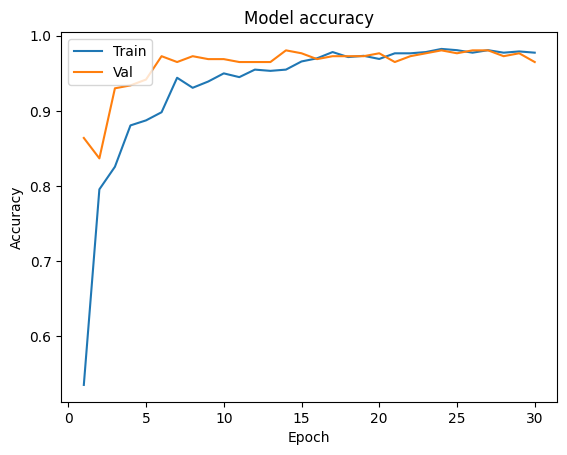

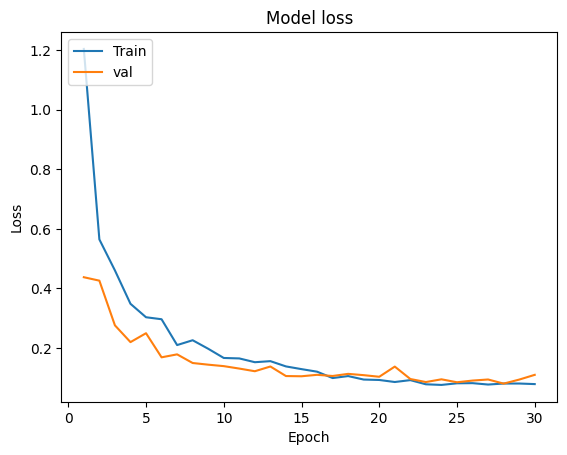

In [ ]:
import matplotlib.pyplot as plt

def plot_learningCurve(history, epoch):
# Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
#Plot training & validation Loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'val'], loc='upper left')
  plt.show()


plot_learningCurve(history, epochs)

In [ ]:
model.save('/content/drive/MyDrive/Saved_Model/vgg16(bs64e29).h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('/content/drive/MyDrive/Saved_Model/vgg16(bs64e29).h5')


evaluation_results = loaded_model.evaluate(testing_set, steps=len(testing_set))

# Extracting metrics
test_loss = evaluation_results[0]
test_accuracy = evaluation_results[1]
precision = evaluation_results[2]  # Assuming precision is the third metric
recall = evaluation_results[3]     # Assuming recall is the fourth metric

print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Precision: {precision}, Recall: {recall}')

4/4 [==============================] - 50s 12s/step - loss: 0.1796 - accuracy: 0.9336 - precision_1: 0.9336 - recall_1: 0.9336
Test Loss: 0.17961086332798004, Test Accuracy: 0.93359375, Precision: 0.93359375, Recall: 0.93359375
